In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/paperspace/anaconda3/envs/python-36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/converted/dblp-scholar-reduced/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar-reduced')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar-reduced/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/converted/dblp-scholar-reduced/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = [],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine', 'inverse_l1'],
                        text_compositions=['average'],
                        numeric_sim_metrics=[],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=False)

Number of inputs to dense layer: 6


# Train model 

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=1, batch_size=8192,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

Train on 432038 samples, validate on 54004 samples
Epoch 1/1
432038/432038 [==============================] - 4s 10us/step - loss: 0.0025 - acc: 0.9994 - val_loss: 0.0031 - val_acc: 0.9994


# Learning curves

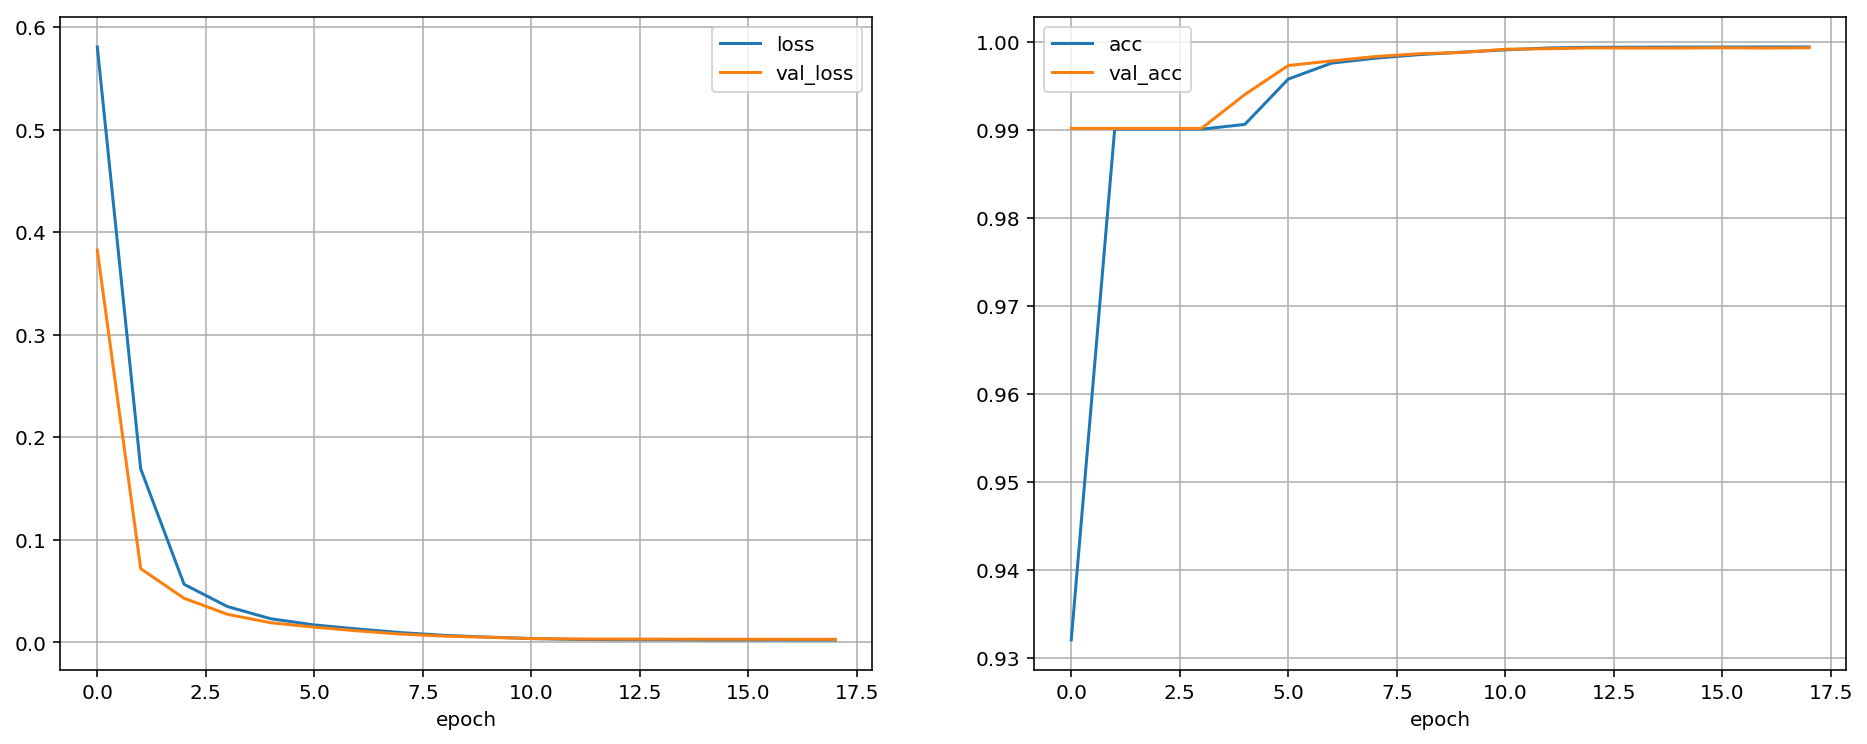

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [29]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     53474
          1       0.98      0.95      0.97       530

avg / total       1.00      1.00      1.00     54004

[[53465     9]
 [   27   503]]


In [30]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,title,authors,venue,year,id2,title,authors,venue,year
43003,conf/sigmod/EmbleyJN99,discovery in web documents,embley jiang ng,sigmod conference,1999,O_SMlr3bFBMJ,jiang and yk discovery in web documents,embley,acm sigmod conf,0.0
7157,conf/vldb/BonczMK99,database architecture optimized for the new bottleneck memory access,boncz manegold kersten,vldb,1999,6GAoBRINv7kJ,databasearchitecture optimizedforthenewbottleneck memoryaccess,boncz manegold kersten,25th international conference on very large data bases,0.0
26814,conf/vldb/GyssensL97,foundation for databases,gyssens lakshmanan,vldb,1997,CfujBHjOpPAJ,foundation for in dayal gray pmd nishio eds,gyssens lvs lakshmanan,nan,1997.0
11699,conf/sigmod/ZhaoDNS98,simultaneous optimization and evaluation of multiple dimensional queries,zhao deshpande naughton shukla,sigmod conference,1998,6AK0GF7jAtsJ,pm deshpande jf naughton shukla simultaneous optimization and evaluation of multiple,zhao,acm sigmod,0.0
13493,conf/vldb/HellersteinNP95,generalized search trees for database systems,hellerstein naughton pfeffer,vldb,1995,SA4P684zTf4J,generalizedsearchtreesfordatabasesystems,jm hellerstein jf naughton,21st very large data bases,0.0


# Save model and histories 

In [31]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar-base-1-allsim.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1-allsim')

# Test model 

In [4]:
model.load_weights('../data/models/dblp-scholar-base-1-allsim')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

             precision    recall  f1-score   support

          0    0.99951   0.99989   0.99970     53467
          1    0.98842   0.95167   0.96970       538

avg / total    0.99940   0.99941   0.99940     54005

[[53461     6]
 [   26   512]]
